# The QNLP Pipeline for Twitter Sentiment Analysis
## 1. Load the preprocessed data

In [1]:
import collections
import pickle
import warnings
warnings.filterwarnings("ignore")
import os
from random import shuffle
import random
from discopy.tensor import Tensor
from discopy import Word
from discopy.rigid import Functor
from discopy import grammar
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from jax import numpy as np
import numpy
from lambeq import AtomicType, IQPAnsatz, remove_cups, NumpyModel, spiders_reader
from lambeq import BobcatParser, TreeReader, cups_reader, DepCCGParser, TreeReaderMode
from lambeq import Dataset
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import TketModel
from lambeq import Rewriter
from pytket.extensions.qiskit import AerBackend
import seaborn as sns
import matplotlib.pyplot as plt
from pytket.circuit.display import render_circuit_jupyter

pd.set_option('display.width', 1000)
pd.options.display.max_colwidth=80
print(os.getcwd())
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
BATCH_SIZE = 50
EPOCHS = 200
SEED = 0

TRAIN_INDEX_RATIO = 0.08
VAL_INDEX_RATIO = TRAIN_INDEX_RATIO + 0.01
TEST_INDEX_RATIO = VAL_INDEX_RATIO + 0.01


assert TEST_INDEX_RATIO <= 1

def load_pickled_dict_to_df(filename):
    saved_dict = pickle.load(open(filename, 'rb'))
    df =  pd.DataFrame.from_dict(saved_dict)
    df =  df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    sentiment = []
    for i in df['target']:
        if i == "Positive":
            sentiment.append(1)
        else:
            sentiment.append(0)
    df["Sentiment"] = sentiment
    return df

cleaned_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data.pkl')
cleaned_lemmatized_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data_lematize.pkl')
cleaned_lemmatized_stemmed_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data_stem_lematize.pkl')

cleaned_qnlp = load_pickled_dict_to_df(cleaned_qnlp_filename)

cleaned_lemmatized_qnlp = load_pickled_dict_to_df(cleaned_lemmatized_qnlp_filename)

cleaned__lemmatized_stemmed_qnlp = load_pickled_dict_to_df(cleaned_lemmatized_stemmed_qnlp_filename)

/home/peiyongw/Desktop/Hackathon-QNLP


In [2]:
cleaned_qnlp.head(10)

,data,label,target,Sentiment
0,king you for your service,"[0, 1]",Positive,1
1,in discussing a typical si amulated internet phishing attack si amply over o...,"[0, 1]",Positive,1
2,oh man see fuck that,"[1, 0]",Negative,0
3,adjust ratings you clowns disrespected hi am going off,"[1, 0]",Negative,0
4,call of duty always got across a fuckin update,"[1, 0]",Negative,0
5,my face watches the riots on facebook,"[1, 0]",Negative,0
6,great servers while playing cl quals and pro league too i guess rubberbandin...,"[0, 1]",Positive,1
7,really enjoying the new vehicles on panzerstorm motor,"[0, 1]",Positive,1
8,did i hate league of legends,"[1, 0]",Negative,0
9,i suppose i can officially say i am addicted to,"[0, 1]",Positive,1


In [3]:
cleaned_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2578 entries, 0 to 2577
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       2578 non-null   object
 1   label      2578 non-null   object
 2   target     2578 non-null   object
 3   Sentiment  2578 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 80.7+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

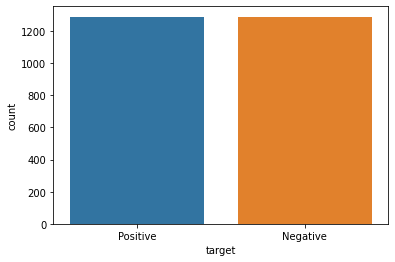

In [4]:
sns.countplot(x = "target", data = cleaned_qnlp)

In [5]:
cleaned_lemmatized_qnlp.head(10)

,data,label,target,Sentiment
0,thank you kevin peesker president,"[0, 1]",Positive,1
1,a sarahschachner i must ve been relistening to the anthemgame assassinscreed...,"[0, 1]",Positive,1
2,i am ded tired,"[1, 0]",Negative,0
3,adjust rating you clown disrespected hi am going off,"[1, 0]",Negative,0
4,i my love call of duty infinite warfare,"[0, 1]",Positive,1
5,and legend never die,"[0, 1]",Positive,1
6,this will also be trash,"[1, 0]",Negative,0
7,did not j j,"[1, 0]",Negative,0
8,did i hate league of legend,"[1, 0]",Negative,0
9,nice player model rhandlerr fix it pic twitter com,"[1, 0]",Negative,0


In [6]:
cleaned_lemmatized_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2578 entries, 0 to 2577
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       2578 non-null   object
 1   label      2578 non-null   object
 2   target     2578 non-null   object
 3   Sentiment  2578 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 80.7+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

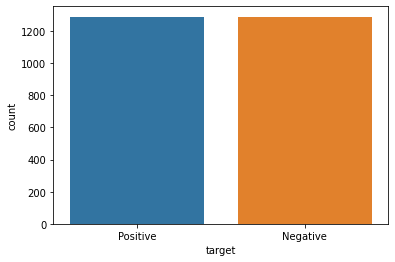

In [7]:
sns.countplot(x='target', data = cleaned_lemmatized_qnlp)

In [8]:
cleaned__lemmatized_stemmed_qnlp.head(10)

,data,label,target,Sentiment
0,king you for your servic,"[0, 1]",Positive,1
1,epic store close hahahah gta v kill it,"[0, 1]",Positive,1
2,fuck no that s back when everybodi didn t miss lmao,"[1, 0]",Negative,0
3,fifa wa so pain,"[1, 0]",Negative,0
4,call of duti alway got across a fuckin updat,"[1, 0]",Negative,0
5,remot work and an increas in cloud base data is spur cyber attack today see ...,"[0, 1]",Positive,1
6,i start be realli into play battlefield hardlin it s differ than most other ...,"[0, 1]",Positive,1
7,fuck sleep got ta watch the reveal trailer for cod black op cold war later a...,"[0, 1]",Positive,1
8,kill yourself and your playoverwatch s fault fuck you,"[1, 0]",Negative,0
9,nice player model rhandlerr fix it pic twitter com,"[1, 0]",Negative,0


In [9]:
cleaned__lemmatized_stemmed_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2578 entries, 0 to 2577
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       2578 non-null   object
 1   label      2578 non-null   object
 2   target     2578 non-null   object
 3   Sentiment  2578 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 80.7+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

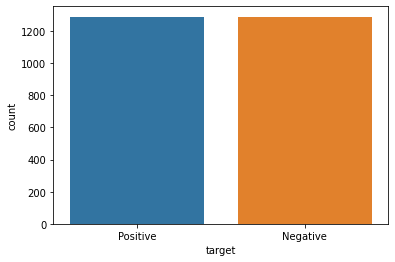

In [10]:
sns.countplot(x='target', data = cleaned__lemmatized_stemmed_qnlp)

## 2. Train QNLP Models for Different-Preprocessed Data
Since the limited parsing and training speed using on the CPU, we'll only use a fraction of our data.

In [11]:
# parser = BobcatParser(verbose='text')
# parser = DepCCGParser(root_cats=['S[dcl]'])
# parser = spiders_reader
parser = TreeReader(mode=TreeReaderMode.RULE_TYPE)
NUM_DATA = 2578

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
rewriter = Rewriter(['prepositional_phrase', 'determiner', 'auxiliary', 'connector', 
                         'coordination', 'object_rel_pronoun', 'subject_rel_pronoun',
                        'postadverb', 'preadverb'])
def rewrite(diagram):
    # diagram = rewriter(diagram)
    return remove_cups(diagram)

def create_diagrams_and_labels(total_df, NUM_DATA = 2578):
    total_text = total_df['data'].tolist()
    total_labels = total_df["Sentiment"].tolist()
    total_labels = [[t, 1-t] for t in total_labels] # [1, 0] for positive, [0, 1] for negative
    train_diagrams = parser.sentences2diagrams(total_text[:round(NUM_DATA*TRAIN_INDEX_RATIO)])
    train_labels = total_labels[:round(NUM_DATA*TRAIN_INDEX_RATIO)]
    dev_diagrams = parser.sentences2diagrams(total_text[round(NUM_DATA*TRAIN_INDEX_RATIO):round(NUM_DATA*VAL_INDEX_RATIO)])
    dev_labels = total_labels[round(NUM_DATA*TRAIN_INDEX_RATIO):round(NUM_DATA*VAL_INDEX_RATIO)]
    test_diagrams = parser.sentences2diagrams(total_text[round(NUM_DATA*VAL_INDEX_RATIO):round(NUM_DATA*TEST_INDEX_RATIO)])
    test_labels = total_labels[round(NUM_DATA*VAL_INDEX_RATIO):round(NUM_DATA*TEST_INDEX_RATIO)]
    
    return train_diagrams, train_labels, dev_diagrams, dev_labels, test_diagrams, test_labels

### 2.1 Data with both Lemmatization and Stemming
#### 2.1.1 Create diagrams

In [12]:
data = cleaned__lemmatized_stemmed_qnlp

In [13]:
raw_train_diagrams_1, train_labels_1, raw_dev_diagrams_1, dev_labels_1, raw_test_diagrams_1, test_labels_1 = create_diagrams_and_labels(data)
print(len(raw_train_diagrams_1))

206


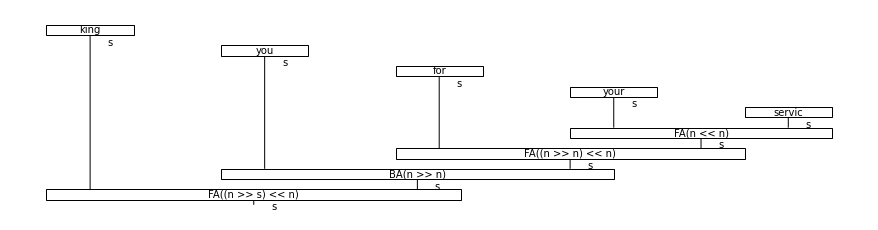

In [14]:
raw_train_diagrams_1[0].draw(figsize=(12,3))

#### 2.1.2 Simplify the diagrams

In [15]:
train_diagrams_1 = [rewrite(diagram) for diagram in raw_train_diagrams_1]
dev_diagrams_1 = [rewrite(diagram) for diagram in raw_dev_diagrams_1]
test_diagrams_1 = [rewrite(diagram) for diagram in raw_test_diagrams_1]

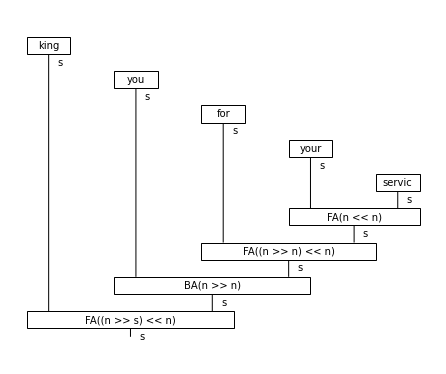

In [16]:
train_diagrams_1[0].draw(figsize=(6,5))

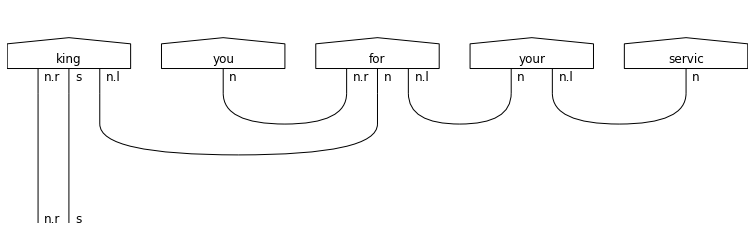

In [17]:
alternate_parser = BobcatParser(verbose='text')
dig_0 = alternate_parser.sentence2diagram(cleaned__lemmatized_stemmed_qnlp['data'].tolist()[0])
grammar.draw(dig_0, figsize=(14,3), fontsize=12)

#### 2.1.3 Create circuits

In [18]:
ansatz_1 = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1, AtomicType.NOUN_PHRASE:1, AtomicType.CONJUNCTION:1}, n_layers=1, n_single_qubit_params=3)
train_circuits_1 = [ansatz_1(diagram) for diagram in train_diagrams_1]
dev_circuits_1 =  [ansatz_1(diagram) for diagram in dev_diagrams_1]
test_circuits_1 = [ansatz_1(diagram) for diagram in test_diagrams_1]

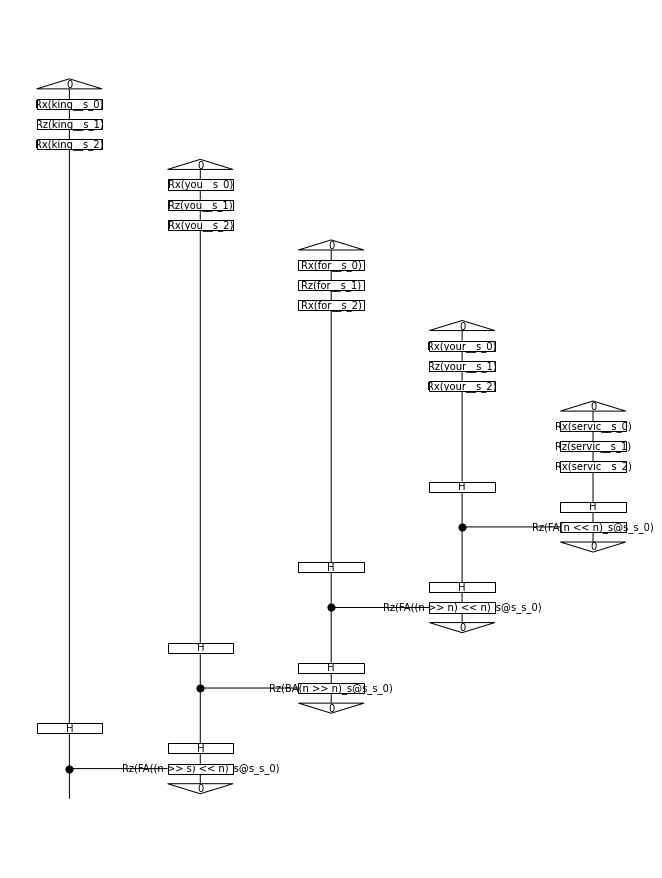

In [19]:
train_circuits_1[0].draw(figsize=(9, 12))

In [20]:
# train_circuits_1[0].draw(figsize=(9, 12))
render_circuit_jupyter(train_circuits_1[0].to_tk())

In [21]:
[(s, s.size) for s in train_circuits_1[0].free_symbols]

[(for__s_0, 1),
 (FA((n >> s) << n)_s@s_s_0, 1),
 (you__s_0, 1),
 (your__s_2, 1),
 (for__s_1, 1),
 (servic__s_2, 1),
 (FA((n >> n) << n)_s@s_s_0, 1),
 (BA(n >> n)_s@s_s_0, 1),
 (servic__s_1, 1),
 (your__s_0, 1),
 (your__s_1, 1),
 (king__s_0, 1),
 (king__s_1, 1),
 (servic__s_0, 1),
 (you__s_1, 1),
 (FA(n << n)_s@s_s_0, 1),
 (you__s_2, 1),
 (king__s_2, 1),
 (for__s_2, 1)]

#### 2.1.4 Parameterise

In [22]:
all_circuits_1 = train_circuits_1 + dev_circuits_1 + test_circuits_1
model_1 = NumpyModel.from_diagrams(all_circuits_1, use_jit=True)
# model_1 = TketModel.from_diagrams(all_circuits_1, backend_config=backend_config)

#### 2.1.5 Initialize trainer

In [23]:
trainer_1 = QuantumTrainer(
    model_1,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)
train_dataset_1 = Dataset(
            train_circuits_1,
            train_labels_1,
            batch_size=BATCH_SIZE)

val_dataset_1 = Dataset(dev_circuits_1, dev_labels_1, shuffle=False)

#### 2.1.6 Train

In [ ]:
trainer_1.fit(train_dataset_1, val_dataset_1, logging_step=1)

Epoch 1:    train/loss: 0.7532   valid/loss: 0.8052   train/acc: 0.5243   valid/acc: 0.5000
Epoch 2:    train/loss: 0.7358   valid/loss: 0.8422   train/acc: 0.5437   valid/acc: 0.3846
Epoch 3:    train/loss: 0.7075   valid/loss: 0.8694   train/acc: 0.5291   valid/acc: 0.3077
Epoch 4:    train/loss: 0.7234   valid/loss: 0.8752   train/acc: 0.5728   valid/acc: 0.2692
Epoch 5:    train/loss: 0.6858   valid/loss: 0.8028   train/acc: 0.5631   valid/acc: 0.5000
Epoch 6:    train/loss: 0.7954   valid/loss: 0.7820   train/acc: 0.5194   valid/acc: 0.5385
Epoch 7:    train/loss: 0.7675   valid/loss: 0.7723   train/acc: 0.4854   valid/acc: 0.4615
Epoch 8:    train/loss: 0.6905   valid/loss: 0.7601   train/acc: 0.5874   valid/acc: 0.5000
Epoch 9:    train/loss: 0.6954   valid/loss: 0.7465   train/acc: 0.5583   valid/acc: 0.5000
Epoch 10:   train/loss: 0.6842   valid/loss: 0.7430   train/acc: 0.5874   valid/acc: 0.4615
Epoch 11:   train/loss: 0.6701   valid/loss: 0.7056   train/acc: 0.5777   valid/

#### 2.1.7 Show Results

In [ ]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(12, 8))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer_1.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer_1.train_results['acc'], color=next(colours))
ax_tr.plot(trainer_1.val_costs, color=next(colours))
ax_br.plot(trainer_1.val_results['acc'], color=next(colours))

### 2.2 Data with only Lemmatization

In [ ]:
data = cleaned_lemmatized_qnlp
raw_train_diagrams_1, train_labels_1, raw_dev_diagrams_1, dev_labels_1, raw_test_diagrams_1, test_labels_1 = create_diagrams_and_labels(data)
print(len(raw_train_diagrams_1))

In [ ]:
raw_train_diagrams_1[0].draw(figsize=(12,3))

In [ ]:
train_diagrams_1 = [rewrite(diagram) for diagram in raw_train_diagrams_1]
dev_diagrams_1 = [rewrite(diagram) for diagram in raw_dev_diagrams_1]
test_diagrams_1 = [rewrite(diagram) for diagram in raw_test_diagrams_1]

In [ ]:
train_diagrams_1[0].draw(figsize=(6,5))

In [ ]:
ansatz_1 = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1, AtomicType.NOUN_PHRASE:1, AtomicType.CONJUNCTION:1}, n_layers=1, n_single_qubit_params=3)
train_circuits_1 = [ansatz_1(diagram) for diagram in train_diagrams_1]
dev_circuits_1 =  [ansatz_1(diagram) for diagram in dev_diagrams_1]
test_circuits_1 = [ansatz_1(diagram) for diagram in test_diagrams_1]

In [ ]:
train_circuits_1[0].draw(figsize=(9, 12))

In [ ]:
render_circuit_jupyter(train_circuits_1[0].to_tk())

In [ ]:
all_circuits_1 = train_circuits_1 + dev_circuits_1 + test_circuits_1
model_1 = NumpyModel.from_diagrams(all_circuits_1, use_jit=True)

In [ ]:
trainer_1 = QuantumTrainer(
    model_1,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)
train_dataset_1 = Dataset(
            train_circuits_1,
            train_labels_1,
            batch_size=BATCH_SIZE)

val_dataset_1 = Dataset(dev_circuits_1, dev_labels_1, shuffle=False)

In [ ]:
trainer_1.fit(train_dataset_1, val_dataset_1, logging_step=1)

In [ ]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(12, 8))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer_1.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer_1.train_results['acc'], color=next(colours))
ax_tr.plot(trainer_1.val_costs, color=next(colours))
ax_br.plot(trainer_1.val_results['acc'], color=next(colours))

### 2.3 Data without Lemmatization or stemming

In [ ]:
data = cleaned_qnlp
raw_train_diagrams_1, train_labels_1, raw_dev_diagrams_1, dev_labels_1, raw_test_diagrams_1, test_labels_1 = create_diagrams_and_labels(data)
print(len(raw_train_diagrams_1))

In [ ]:
raw_train_diagrams_1[0].draw(figsize=(12,3))

In [ ]:
train_diagrams_1 = [rewrite(diagram) for diagram in raw_train_diagrams_1]
dev_diagrams_1 = [rewrite(diagram) for diagram in raw_dev_diagrams_1]
test_diagrams_1 = [rewrite(diagram) for diagram in raw_test_diagrams_1]

In [ ]:
train_diagrams_1[0].draw(figsize=(6,5))

In [ ]:
render_circuit_jupyter(train_circuits_1[0].to_tk())

In [ ]:
all_circuits_1 = train_circuits_1 + dev_circuits_1 + test_circuits_1
model_1 = NumpyModel.from_diagrams(all_circuits_1, use_jit=True)

In [ ]:
trainer_1 = QuantumTrainer(
    model_1,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)
train_dataset_1 = Dataset(
            train_circuits_1,
            train_labels_1,
            batch_size=BATCH_SIZE)

val_dataset_1 = Dataset(dev_circuits_1, dev_labels_1, shuffle=False)

In [ ]:
trainer_1.fit(train_dataset_1, val_dataset_1, logging_step=1)

In [ ]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(12, 8))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer_1.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer_1.train_results['acc'], color=next(colours))
ax_tr.plot(trainer_1.val_costs, color=next(colours))
ax_br.plot(trainer_1.val_results['acc'], color=next(colours))